In [ ]:
# this full connected deep learning model is no difference from the short-term-data's model

In [39]:
import pandas as pd
import numpy as np

path = 'C:/software/WinPython/notebooks/indoor position/long_term_datasets'
train_rss = pd.read_csv(path + '/train_rss.csv',header  = None)
train_coord = pd.read_csv(path + '/train_coords.csv', header  = None)

test_rss = pd.read_csv(path + '/test_rss.csv',header  = None)
test_coord = pd.read_csv(path + '/test_coords.csv',header  = None)


In [40]:
print(train_rss.shape)
print(test_rss.shape)

(16704, 448)
(46800, 448)


In [41]:

train = pd.concat([train_rss, train_coord], axis=1, ignore_index=True)
test = pd.concat([test_rss, test_coord], axis=1, ignore_index=True)
train_replace = train.replace(100,0)
train_ar = train_replace.values
test_replace = test.replace(100,0)
test_ar = test_replace.values
print(train_ar)

[[-90.    -62.    -69.    ...,  12.904  29.208   3.   ]
 [-93.    -65.    -67.    ...,  12.904  29.208   3.   ]
 [-88.    -64.    -68.    ...,  12.904  29.208   3.   ]
 ..., 
 [  0.      0.      0.    ...,  12.904  29.208   5.   ]
 [  0.      0.      0.    ...,  12.904  29.208   5.   ]
 [  0.      0.      0.    ...,  12.904  29.208   5.   ]]


In [42]:
train3=train_ar[train_ar[:,-1]==3]
train3_rss = train3[:, 0:448]
train3_coord = train3[:,448:450]

test3=test_ar[test_ar[:,-1]==3]
test3_rss = test3[0:5000, 0:448]
test3_coord = test3[0:5000, 448:450]


train5 = train_ar[train_ar[:,-1]==5]
train5_rss = train5[:, 0:448]
train5_coord = train5[:, 448:450]

test5=test_ar[test_ar[:,-1]==5]
test5_rss = test5[0:5000, 0:448]
test5_coord = test5[0:5000, 448:450]

In [43]:
print(test3_rss, test3_coord)
print(train5_rss.shape)

[[-87. -54. -57. ...,   0.   0.   0.]
 [  0. -54. -55. ...,   0.   0.   0.]
 [-88. -52. -56. ...,   0.   0.   0.]
 ..., 
 [  0. -62. -66. ...,   0.   0.   0.]
 [  0. -64. -62. ...,   0.   0.   0.]
 [  0. -61. -61. ...,   0.   0.   0.]] [[ 12.904   29.208 ]
 [ 12.904   29.208 ]
 [ 12.904   29.208 ]
 ..., 
 [  9.5149  27.419 ]
 [  5.1254  27.419 ]
 [  5.1254  27.419 ]]
(8352, 448)


In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop, Adadelta, Adam
import matplotlib.pyplot as plt
from keras import regularizers
import sklearn
from sklearn import svm
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Input

def predata(rss, locations):
    # the origin of the room
    origin = np.amin(locations,axis=0)
    #size of the room
    room_size = np.amax(locations, axis=0)-origin
    # position respect to origin
    train_Yy = locations - origin
    train_Xx = np.asarray(rss, dtype=np.float64) 
    return train_Xx, train_Yy

In [45]:
def train_val(rss, locations):
    train_Xx, train_Yy = predata(rss, locations)
    train_x, val_x, train_y, val_y = train_test_split(train_Xx, train_Yy, test_size=0.25)
    return train_x, val_x, train_y, val_y

In [46]:
def accuracy(predictions, labels):
    error = np.sqrt(np.sum((predictions - labels)**2, 1))
    return error, np.mean(error)

In [47]:

def train_model(rss, locations, test_rss, test_locations):
    # get train_X, val_X, train_Y, val_Y
    train_X, val_X, train_Y, val_Y = train_val(rss, locations)
    test_X, test_Y = predata(test_rss, test_locations)
    
    # parameters
    num_input = train_X.shape[1]# input layer size
    act_fun = 'relu'
    regularzation_penalty = 0.03
    initilization_method = 'he_normal' #'random_uniform' ,'random_normal','TruncatedNormal' ,'glorot_uniform', 'glorot_nomral', 'he_normal', 'he_uniform'
    #Optimizer
    adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    # define model

    model = Sequential()
    model.add(Dense(128, activation=act_fun, input_dim=num_input, kernel_initializer=initilization_method ,kernel_regularizer=regularizers.l2(regularzation_penalty)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation=act_fun, kernel_initializer=initilization_method ,kernel_regularizer=regularizers.l2(regularzation_penalty)))
    model.add(Dropout(0.5))
#     model.add(Dense(128, activation=act_fun, kernel_initializer=initilization_method ,kernel_regularizer=regularizers.l2(regularzation_penalty)))
#     model.add(Dropout(0.5))
    model.add(Dense(2, activation='linear', kernel_initializer=initilization_method ,kernel_regularizer=regularizers.l2(regularzation_penalty)))

    #Model compile
    model.compile(loss='mean_squared_error',
                  optimizer=adam)
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=60, verbose=0, mode='auto')
    model.fit(train_X, train_Y,
              epochs=100,
              batch_size=64,callbacks=[earlyStopping],validation_data=(val_X, val_Y))#tbCallBack,
    #model evaluate
    train_loss = model.evaluate(train_X,train_Y, batch_size=len(train_Y)) #calculate the data in test mode(Keras)
    val_loss = model.evaluate(val_X, val_Y, batch_size=len(val_Y))
    test_loss = model.evaluate(test_X, test_Y, batch_size=len(test_Y))
    print("Loss for training data is",train_loss)
    print("Loss for validation data is",val_loss)
    print("Loss for test data is",test_loss)
    predict_Y = model.predict(test_X)
    error_t, accuracy_t = accuracy(predict_Y, test_Y)
    return predict_Y, error_t, accuracy_t

In [52]:
predict5, error5, accuracy5 = train_model(train5_rss, train5_coord, test5_rss, test5_coord)

Train on 6264 samples, validate on 2088 samples
Epoch 1/100
6264/6264 [==============================] - 0s - loss: 194.1658 - val_loss: 27.8117
Epoch 2/100
6264/6264 [==============================] - 0s - loss: 52.9678 - val_loss: 24.5952
Epoch 3/100
6264/6264 [==============================] - 0s - loss: 34.8002 - val_loss: 23.3429
Epoch 4/100
6264/6264 [==============================] - 0s - loss: 29.0777 - val_loss: 21.2888
Epoch 5/100
6264/6264 [==============================] - 0s - loss: 24.9774 - val_loss: 19.5265
Epoch 6/100
6264/6264 [==============================] - 0s - loss: 23.0734 - val_loss: 20.2018
Epoch 7/100
6264/6264 [==============================] - 0s - loss: 21.3448 - val_loss: 18.3024
Epoch 8/100
6264/6264 [==============================] - 0s - loss: 20.2751 - val_loss: 18.0328
Epoch 9/100
6264/6264 [==============================] - 0s - loss: 19.1352 - val_loss: 16.8172
Epoch 10/100
6264/6264 [==============================] - 0s - loss: 18.1646 - val_loss

6264/6264 [==============================] - 0s - loss: 5.5821 - val_loss: 4.6284
Epoch 87/100
6264/6264 [==============================] - 0s - loss: 5.4087 - val_loss: 4.3749
Epoch 88/100
6264/6264 [==============================] - 0s - loss: 5.4063 - val_loss: 4.8602
Epoch 89/100
6264/6264 [==============================] - 0s - loss: 5.4360 - val_loss: 4.3189
Epoch 90/100
6264/6264 [==============================] - 0s - loss: 5.3037 - val_loss: 4.6819
Epoch 91/100
6264/6264 [==============================] - 0s - loss: 5.3377 - val_loss: 4.3749
Epoch 92/100
6264/6264 [==============================] - 0s - loss: 5.2732 - val_loss: 4.4165
Epoch 93/100
6264/6264 [==============================] - 0s - loss: 5.1764 - val_loss: 4.1866
Epoch 94/100
6264/6264 [==============================] - 0s - loss: 5.1634 - val_loss: 4.2528
Epoch 95/100
6264/6264 [==============================] - 0s - loss: 5.1797 - val_loss: 4.3028
Epoch 96/100
6264/6264 [==============================] - 0s - 

In [49]:
print('The average error:', accuracy5)

The average error: 3.30178222565


In [50]:
print('minimum error:', np.amin(error5), 'maximum error:', np.amax(error5), 'variance:', 
      np.var(error5), "75%:", np.percentile(error5, 75))

minimum error: 0.0343681916991 maximum error: 9.24152428984 variance: 2.75592794414 75%: 4.4298916034


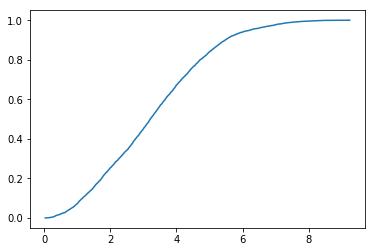

In [51]:
error_sorted= np.sort(error5)
p = 1. *np.arange(len(error5))/(len(error5)-1)
plt.plot(error_sorted, p)
plt.show()

In [56]:
x = np.arange(129*4)

x = x.reshape(129, 4)


In [57]:
a = np.vsplit(x, np.arange(6, 129, 6))
print(a[0].shape)

print(a[-1].shape)


(6, 4)
(3, 4)


In [55]:
print(a[1].shape[1:])

(4, 12)
